KEY QUESTION:
1. HOW DO THE BOOKS CHANGE OVER TIME?
    * Temporal analysis of the book graphs
    * Word-cloud for each book + Evolution of LIX-score over time
        * Make pretty
2. HOW DO THE CHARACTERS, THEIR INTERACTIONS / RELATIONSHIPS, AND LANGUAGE SURROUNDING THEM CHANGE THROUGHOUT KEY MOMENTS IN THE HARRY POTTER BOOKS?
    * Key moments:
        * Moments with heavy character interaction changes
            
            1. Muggle world vs. Wizarding world: Book 1, Chapter 3 vs. Book 1, Chapter 17
            2. The establishment of Dumbledore's Army: Book 5, Chapter 18 vs. Book 5, Chapter 28
        * Moments with heavy character specific changes (on graphs look for changes in community and edge weight to Lord Voldemort)
            
            3. Snape's true allegiance: Book 6, Chapter 26 vs. Book 7, Chapter 33
                * Severus Snape, Harry Potter, Lily Potter, James Potter, Albus Dumbledore (?), Lord Voldemort (?)
            4. Sirius Black's and Peter Pettigrew's true allegiance: Book 3, Chapter 10 vs. Book 3, Chapter 19
                * Sirius Black, Peter Pettigrew, Remus Lupin, Severus Snape (?), Harry Potter (?), Ron Weasley (?), Hermione Granger (?)
    * Analysis:
        * Character graphs (Comparison of the two graphs at the beginning and end of the key moment)
            * Confusion matrix
            * Community detection
            * Centrality measures (Pagerank, Betweenness, Closeness, Degree)
            * Modularity scores
            * Degree assortativity coefficient 
        * Character word-clouds
            * Wordcloud for the fist and last chapter of each moment for the following characters:
                * top 5 most central nodes for moments 1-2
                * named characters for moments 3-4
        * Character sentiment analysis
            * Sentiment analysis over the chapters that define the moment

Nice to have:
(8. Moody's true identity: Book 4, Chapter 14 vs. Book 4, Chapter 35)

KEY QUESTIONS FOR LAURA:
* Graphs: Should we split the graphs between books or keep them together and expand across all books? (Expanding networks within books or in total?)
* Graphs: How do you analyze an expanding network? (How do you analyze the change in the network over time?)
* Graphs: How do you best analyze changes in subcommunities over time?
* Text: Sentiment analysis based on mean sentiment of the occurances in a chapter vs. a point estimate based on all the text in a chapter?
* Text: Better library to use for sentiment analysis then nltk?
* Text: How do you analyze the change in sentiment over time? How do generally analyze dynamically changing text?
* Text: Dynamic text and word clouds?

In [2]:
# General imports
import pickle as pkl
import numpy as np
import pandas as pd
from tqdm import tqdm
from operator import itemgetter

# Text spectific imports
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
# nltk.download(["vader_lexicon"])
import textstat
import pyphen

# Visualization imports
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

# Filename of all dynamic data
filename = 'temp/Dynamic_text.pkl'

from Utils.get_text import *

# 2. Basic Stats
## Text

### 2.1. Choices in data cleaning and preprocessing

For the text analysis, we utilized the books as a dynamic dataset in two ways:
1. We analyzed the books as whole books (i.e. the text of a full book ascribed to that book), to answer research question 1 for the global books how these changed over time

### Functions
#### Import text data

In [3]:
# Load characters wiki
character_df = pd.read_csv("1.Dataset_files/CharacterWikis_clean.csv")
character_df.Aliases = [eval(char) for char in character_df.Aliases]
character_df.Tokens = [eval(t) for t in character_df.Tokens]

# dict so we have all nodes (list of dicts of all character names (str) and their aliases (list of str)))
characters = [{'name': character_df['Name'].iloc[i], 'aliases': character_df['Aliases'].iloc[i]} for i in range(len(character_df))]

print(f" Number of characters: {len(characters)}, number of aliases: {sum([len(char['aliases']) for char in characters])}")

 Number of characters: 677, number of aliases: 1323


Characters_dynamic_text = {}

for char in tqdm(characters):
    Char_book_text = {}

    for book_nr in range(1,8):
        # Load formatted book (dict of chapters with list of lists of pages and sentences)
        with open(f"1.Dataset_files/Books_formatted/Book{book_nr}.pkl","rb") as f:
            book = pkl.load(f)
        
        Char_book_text[book_nr] = text_book(char['aliases'], book)

    Characters_dynamic_text[char['name']] = Char_book_text

with open(f"Temp/Dynamic_text.pkl","wb") as f:
    pkl.dump(Characters_dynamic_text,f)
   

#### Get text for a specific character and a specific segment of the books

In [4]:
books = {nr: [] for nr in range(1,8)}
for book_nr in range(1,8):
        # Load formatted book (dict of chapters with list of lists of pages and sentences)
    with open(f"1.Dataset_files/Books_formatted/Book{book_nr}.pkl","rb") as f:
        book = pkl.load(f)

    for chapter in book.values():
        for page in chapter:
            books[book_nr].extend([token for sent in page for token in tokenize(sent)])

In [5]:
# Load the data
with open(filename, 'rb') as f:
    alltexts = pkl.load(f)

In [6]:
def get_text(start: list = [1, 1], stop: list = [7, 37], characters_to_get: list = []) -> dict:
    """
    Returns a dict of the characters and their text for the window between start and stop.
    start: list of [book, chapter]
    stop: list of [book, chapter]
    characters: list of of all characters we want to get the text from. Note that this should be the character name, not the aliases.
    """
    text_dict = {name: [] for name in characters_to_get}
    
    for char in characters_to_get:
        temp = {booknr: alltexts[char].get(booknr) for booknr in range(start[0], stop[0]+1)}
        for booknr in range(start[0], stop[0]+1):
            if start[0] == stop[0]:
                # add the text from the start to stop chapters of that one book 
                text_dict[char].append([text['text'] for text in itemgetter(*range(start[1], stop[1]+1))(temp[booknr])])
            
            else: 
                if booknr == start[0]:
                    # add the text from the start book starting from the start chapter to the end
                    text_dict[char].append([text['text'] for text in itemgetter(*range(start[1], len(temp[booknr])+1))(temp[booknr])])
                elif booknr == stop[0]:
                    # add the text from the stop book starting from the start to the stop chapter
                    text_dict[char].append([text['text'] for text in itemgetter(*range(1, stop[1]+1))(temp[booknr])])
                else:
                    # add the text from the middle books completely
                    text_dict[char].append([text['text'] for text in temp[booknr].values()])
    return text_dict

#### TF-IDF / Wordcloud functions

In [7]:
# Get the vocabulary of all characters
all_words = set()
for book in books.values():
        all_words = all_words.union(book)

In [8]:
# Get document term count (document = chapter)
def get_doc_term_count(documents: dict = alltexts, all_terms: set = all_words):
    doc_term_count = {}
    for term in tqdm(all_terms):
        for char in documents.keys():
            for book in documents[char].values():
                doc_term_count.update({term: doc_term_count.get(term, 0) + sum([1 for chapter in book.values() if term in chapter['tokens']])})

    return doc_term_count

doc_term_count = get_doc_term_count()

100%|██████████| 20343/20343 [20:49<00:00, 16.28it/s]


In [9]:
# Calculate tf
def calc_tf(character: str = "", position: list = [1,1], documents: list = alltexts):
    terms = documents[character][position[0]][position[1]]['tokens']
    frequency = nltk.FreqDist(terms)

    sum_terms = len(terms)
    tf = {word: freq/sum_terms for word, freq in frequency.items() if word not in [el.lower() for char in characters for el in char['name'].split(' ')] + ['said']}

    return tf

# Calculate idf
def calc_idf(position: list = [1,1], documents: dict = alltexts, all_terms: set = all_words, doc_term: dict = doc_term_count):
    
    N = sum([len(alltexts['Harry Potter'][i]) for i in range(1,8)])*len([char['name'] for char in characters])
    idf = {word: np.log2(N/(1 + doc_term[word])) for word in all_terms}

    return idf

# Calculate tf-idf
def calc_tf_idf(character: str = "", position: list = [1,1]):
    tf = calc_tf(character = character, position = position)
    idf = calc_idf(position = position)
    tf_idf = {word: tf[word] * idf[word] for word in tf.keys()}

    return tf_idf

def plot_wordcloud(characters_to_get: list = [], position: list = [1,1], mask: list = None, colormap: list = ["OrRd"]):
    fig, ax = plt.subplots(len(characters_to_get), 1, figsize=(20,10), constrained_layout=True)
    for i, char in enumerate(characters_to_get):
        if mask is not None:
            mask1 = np.array(Image.open(mask[i]))
            mask1 = np.where(mask1==0, 255, mask1)
            wordcloud = WordCloud(background_color="white",
                                mask=mask1,
                                contour_color='black',
                                contour_width=1,
                                colormap=colormap[i]
                                ).generate_from_frequencies(calc_tf_idf(character=char, position=position))
        else:
            wordcloud = WordCloud(background_color="white",
                                    colormap=colormap[i]
                                    ).generate_from_frequencies(calc_tf_idf(character=char, position=position))
        
        ax[i].imshow(wordcloud, interpolation='bilinear')
        ax[i].set_title(f"Wordcloud of {char} in book {position[0]}, chapter {position[1]}", fontsize=20)
        ax[i].axis("off")
    plt.show()

In [10]:
# Get document term count (document = book)
def get_doc_term_count_books(documents: dict = books, all_terms: set = all_words):
    doc_term_count_book = {}
    for term in tqdm(all_terms):
        doc_term_count_book.update({term: sum([1 for book in books.values() if term in book])})

    return doc_term_count_book

doc_term_count_book = get_doc_term_count_books()

100%|██████████| 20343/20343 [04:00<00:00, 84.59it/s] 


In [11]:
# Calculate tf
def calc_tf_book(booknr: int = 1, documents: list = books):
    terms = documents[booknr]
    frequency = nltk.FreqDist(terms)

    sum_terms = len(terms)
    tf = {word: freq/sum_terms for word, freq in frequency.items() if word not in [el.lower() for char in characters for el in char['name'].split(' ')] + ['said']}

    return tf

# Calculate idf
def calc_idf_book(booknr: int = 1, documents: dict = books, all_terms: set = all_words, doc_term: dict = doc_term_count_book):
    
    N = len(books)
    idf = {word: np.log2(N/(1 + doc_term[word])) for word in all_terms}
    return idf

# Calculate tf-idf
def calc_tf_idf_book(booknr: int = 1):
    tf = calc_tf_book(booknr = booknr)
    idf = calc_idf_book(booknr = booknr)
    tf_idf = {word: tf[word] * idf[word] for word in tf.keys()}

    return tf_idf

def plot_wordcloud_book(mask: list = None, colormap: list = ["OrRd"]):
    fig, ax = plt.subplots(1, 7, figsize=(30,10), constrained_layout=True)

    for booknr in range(1,8):
        if mask is not None:
            mask1 = np.array(Image.open(mask[i]))
            mask1 = np.where(mask1==0, 255, mask1)
            wordcloud = WordCloud(background_color="white",
                                mask=mask1,
                                contour_color='black',
                                contour_width=1,
                                colormap=colormap[0]
                                ).generate_from_frequencies(calc_tf_idf_book(booknr = booknr))
        else:
            wordcloud = WordCloud(background_color="white",
                                    colormap=colormap[0]
                                    ).generate_from_frequencies(calc_tf_idf_book(booknr = booknr))
        
        ax[booknr-1].imshow(wordcloud, interpolation='bilinear')
        ax[booknr-1].set_title(f"Wordcloud for book {booknr}", fontsize=20)
        ax[booknr-1].axis("off")
    plt.show()

#### LIX-score

In [12]:
def get_flesch_reading_ease(text: list) -> float:
    """
    Returns the Flesch reading ease score for a given text.
    
    Input is a list of sentences.
    """
    n_words = sum([len(sent.split(' ')) for sent in text])
    n_sents = len(text)

    hyphenator = pyphen.Pyphen(lang='en_UK')
    n_syllables = 0
    for sent in text:
        sent = sent.lower()
        n_syllables += len([string for string in re.split('-|\s', hyphenator.inserted(sent)) if string != ''])

    return 206.835 - 1.015*(n_words/n_sents) - 84.6*(n_syllables/n_words)

#### Sentiment functions

In [13]:
# Get the sentiment of text
def get_sentiment(text: dict) -> dict:
    """
    Returns a dict of the characters and their sentiment for the window between start and stop.
    text: dict of the characters and their text
    """
    sid = SentimentIntensityAnalyzer()
    sentiment_mean = {name: [] for name in text.keys()}
    sentiment_se = {name: [] for name in text.keys()}
    
    for char in text.keys():
        for book in text[char]:
            for chapter in book:
                if chapter == [[]] or chapter == []:
                    sentiment_mean[char].append(np.nan)
                    sentiment_se[char].append(np.nan)
                else:
                    chapter_sentiments = []
                    for sentence in chapter:
                        chapter_sentiments.append(sid.polarity_scores(sentence)['compound'])

                    sentiment_mean[char].append(np.nanmean(chapter_sentiments))
                    sentiment_se[char].append(np.nanstd(chapter_sentiments)/np.sqrt(len(chapter_sentiments)))

    return sentiment_mean, sentiment_se

def plot_sentiment(start: list = [1, 1], stop: list = [7, 37], characters_to_get: list = [],
colors: list = ['tab: blue', 'tab: orange', 'tab: green', 'tab: red', 'tab: purple', 'tab: brown', 'tab: pink', 'tab: gray', 'tab: olive', 'tab: cyan']):
    """
    Plots the sentiment of the characters in the window between start and stop.
    """
    fig, ax = plt.subplots( len(characters_to_get),
                            1, figsize = (25, 10) #*len(characters_to_get))
                            , constrained_layout=True, sharex=True)

    text_dict = get_text(start, stop, characters_to_get)
    sentiment_mean, sentiment_se = get_sentiment(text_dict)
    for i, (char, sentiment) in enumerate(sentiment_mean.items()):
        ax[i].plot(sentiment, label=char, color = colors[i])
        ax[i].fill_between(range(len(sentiment)), sentiment - 1.96*np.array(sentiment_se[char]), sentiment + 1.96*np.array(sentiment_se[char]), alpha = 0.5, color = colors[i])
        ax[i].axhline(0, color='grey', linestyle='--')
        ax[i].set_xlim(0, len(sentiment_mean[characters_to_get[0]])-1)
        ax[i].set_ylim(-1, 1)
        ax[i].set_title(f"Sentiment for {char} between {start[0]}, {start[1]} and {stop[0]}, {stop[1]}")

    chapters = [17, 18, 22, 37, 38, 30, 37]

    # Create xlabel for the plot in the form of "Book x, Chapter x"
    xlabel = []
    curr_book = start[0]
    curr_chapter = start[1]

    for i in range(len(sentiment_mean[characters_to_get[0]])):
        if curr_chapter <= chapters[curr_book-1]:
            xlabel.append(f"Book {curr_book}, Chapter {curr_chapter}")
            curr_chapter += 1
        else:
            curr_book += 1
            curr_chapter = 1
            xlabel.append(f"Book {curr_book}, Chapter {curr_chapter}")
            curr_chapter += 1

    ax[-1].set_xticks(range(len(sentiment_mean[characters_to_get[0]])), xlabel, rotation=90)
    ax[-1].set_ylabel("Sentiment")
    ax[-1].set_xlabel("Book, Chapter")

    plt.show()

### Output

#### HOW DO THE BOOKS CHANGE OVER TIME?

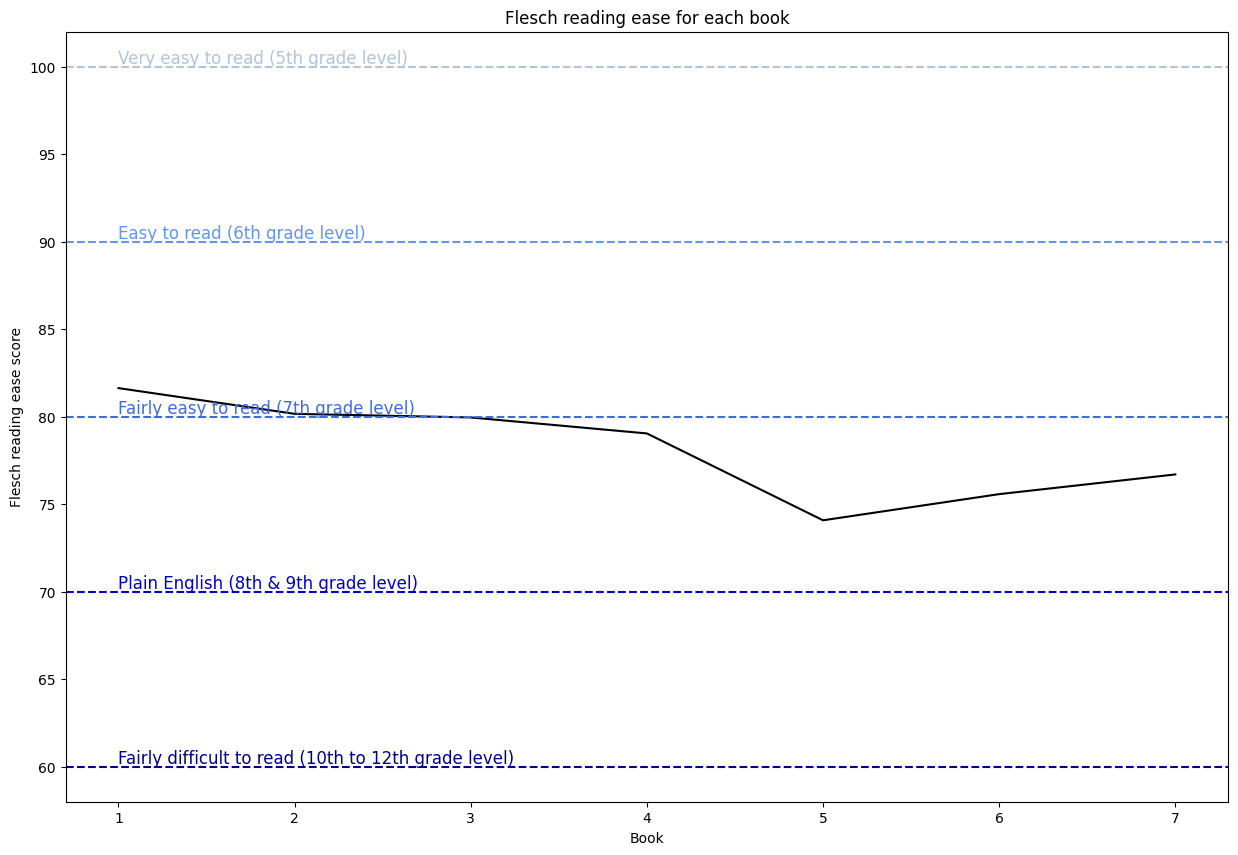

In [14]:
flesch_reading_ease = []

for book_nr in range(1,8):
    with open(f"1.Dataset_files/Books_formatted/Book{book_nr}.pkl","rb") as f:
        book = pkl.load(f)

    booktext = []
    for chapternr in book.keys():
        booktext.extend([sent for page in book[chapternr] for sent in page])

    flesch_reading_ease.append(get_flesch_reading_ease(booktext))

fig, axs = plt.subplots(1,1, figsize=(15,10))

plt.plot(range(1,8), flesch_reading_ease, color = 'k', label = "Flesch reading ease score")

# Flesch reading ease context
plt.axhline(100, color='lightsteelblue', linestyle='--')
plt.axhline(90, color='cornflowerblue', linestyle='--')
plt.axhline(80, color='royalblue', linestyle='--')
plt.axhline(70, color='mediumblue', linestyle='--')
plt.axhline(60, color='darkblue', linestyle='--')

# text labels
plt.text(1, 100.2, "Very easy to read (5th grade level)", fontsize=12, color='lightsteelblue')
plt.text(1, 90.2, "Easy to read (6th grade level)", fontsize=12, color='cornflowerblue')
plt.text(1, 80.2, "Fairly easy to read (7th grade level)", fontsize=12, color='royalblue')
plt.text(1, 70.2, "Plain English (8th & 9th grade level)", fontsize=12, color='mediumblue')
plt.text(1, 60.2, "Fairly difficult to read (10th to 12th grade level)", fontsize=12, color='darkblue')

plt.title("Flesch reading ease for each book")
plt.xlabel("Book")
plt.ylabel("Flesch reading ease score")
plt.show()

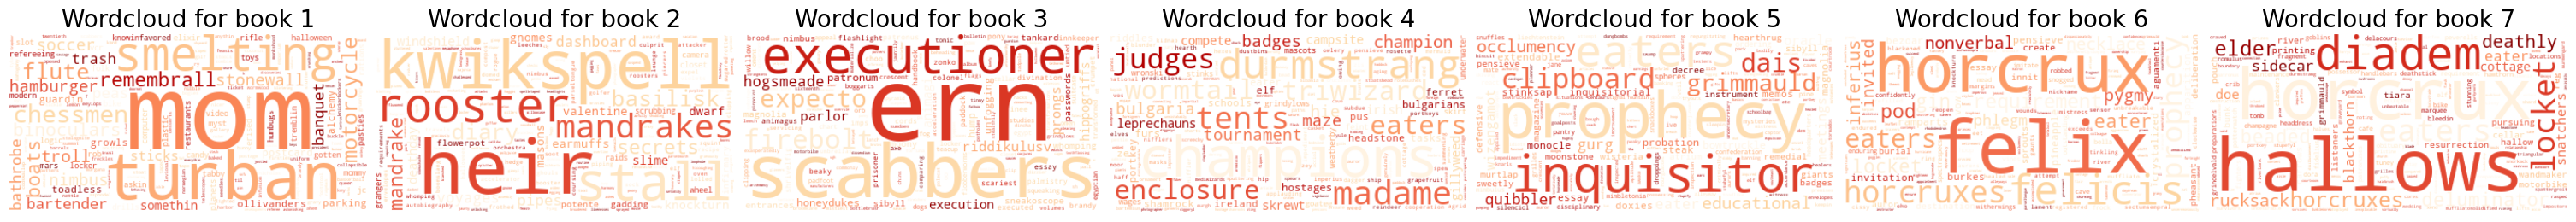

In [15]:
plot_wordcloud_book()

#### Muggle World vs. Wizarding World

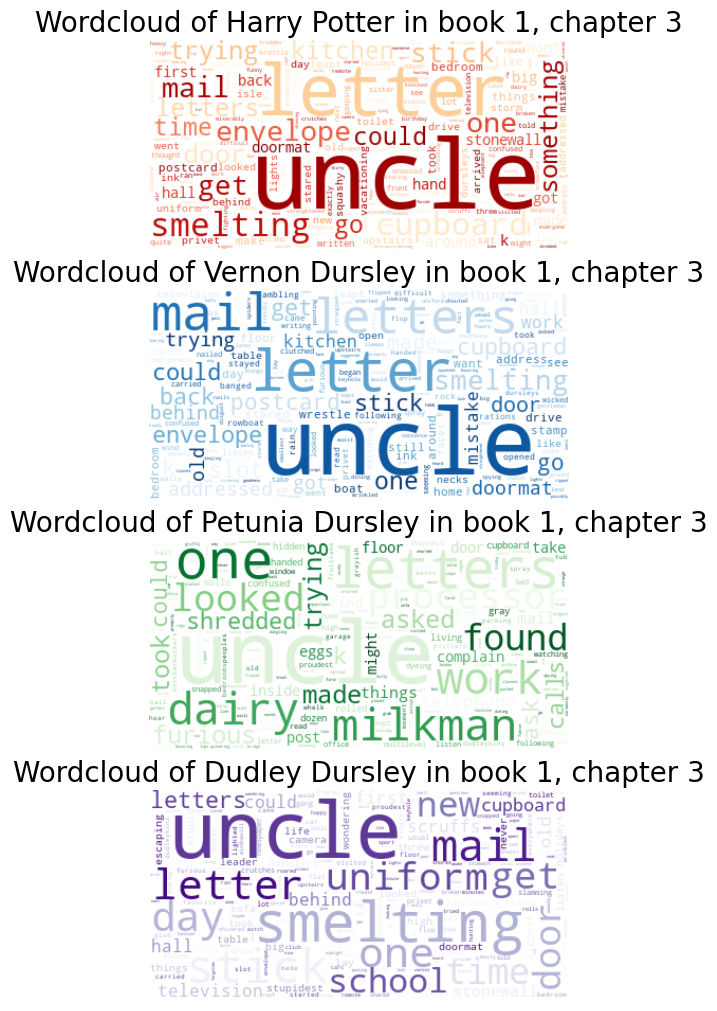

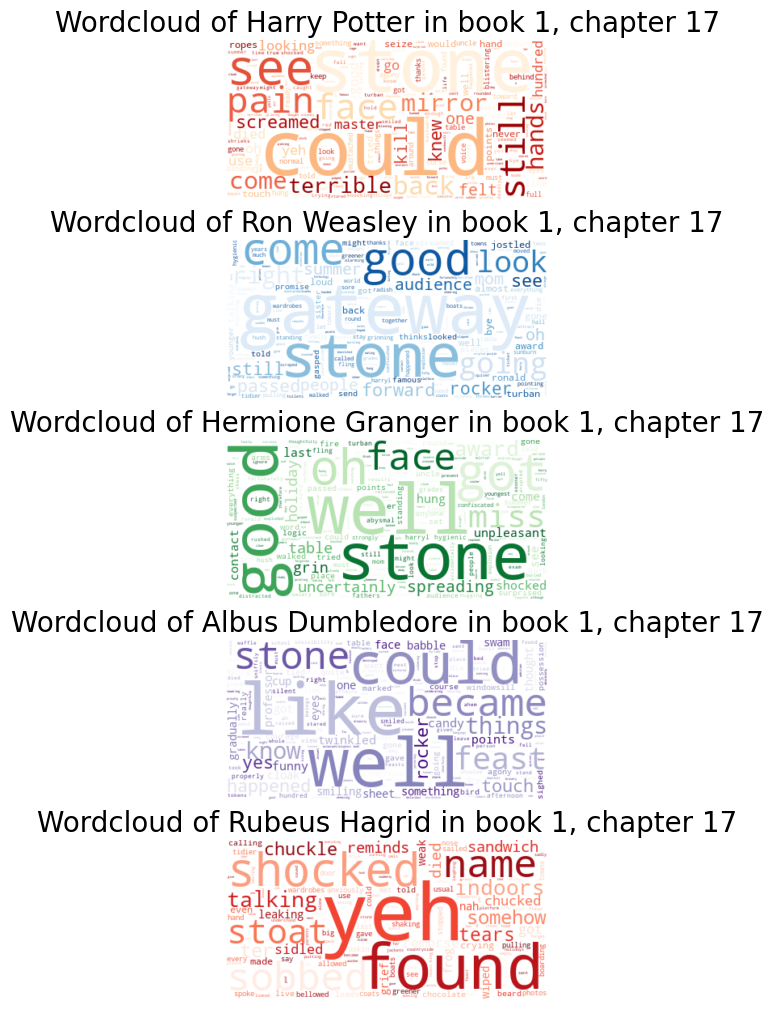

In [16]:
plot_wordcloud(characters_to_get=['Harry Potter', 'Vernon Dursley', 'Petunia Dursley', 'Dudley Dursley'], position=[1,3], colormap=['OrRd', 'Blues', 'Greens', 'Purples'])
plot_wordcloud(characters_to_get=['Harry Potter', 'Ron Weasley', 'Hermione Granger', 'Albus Dumbledore', 'Rubeus Hagrid'], position=[1,17], colormap=['OrRd', 'Blues', 'Greens', 'Purples', 'Reds'])

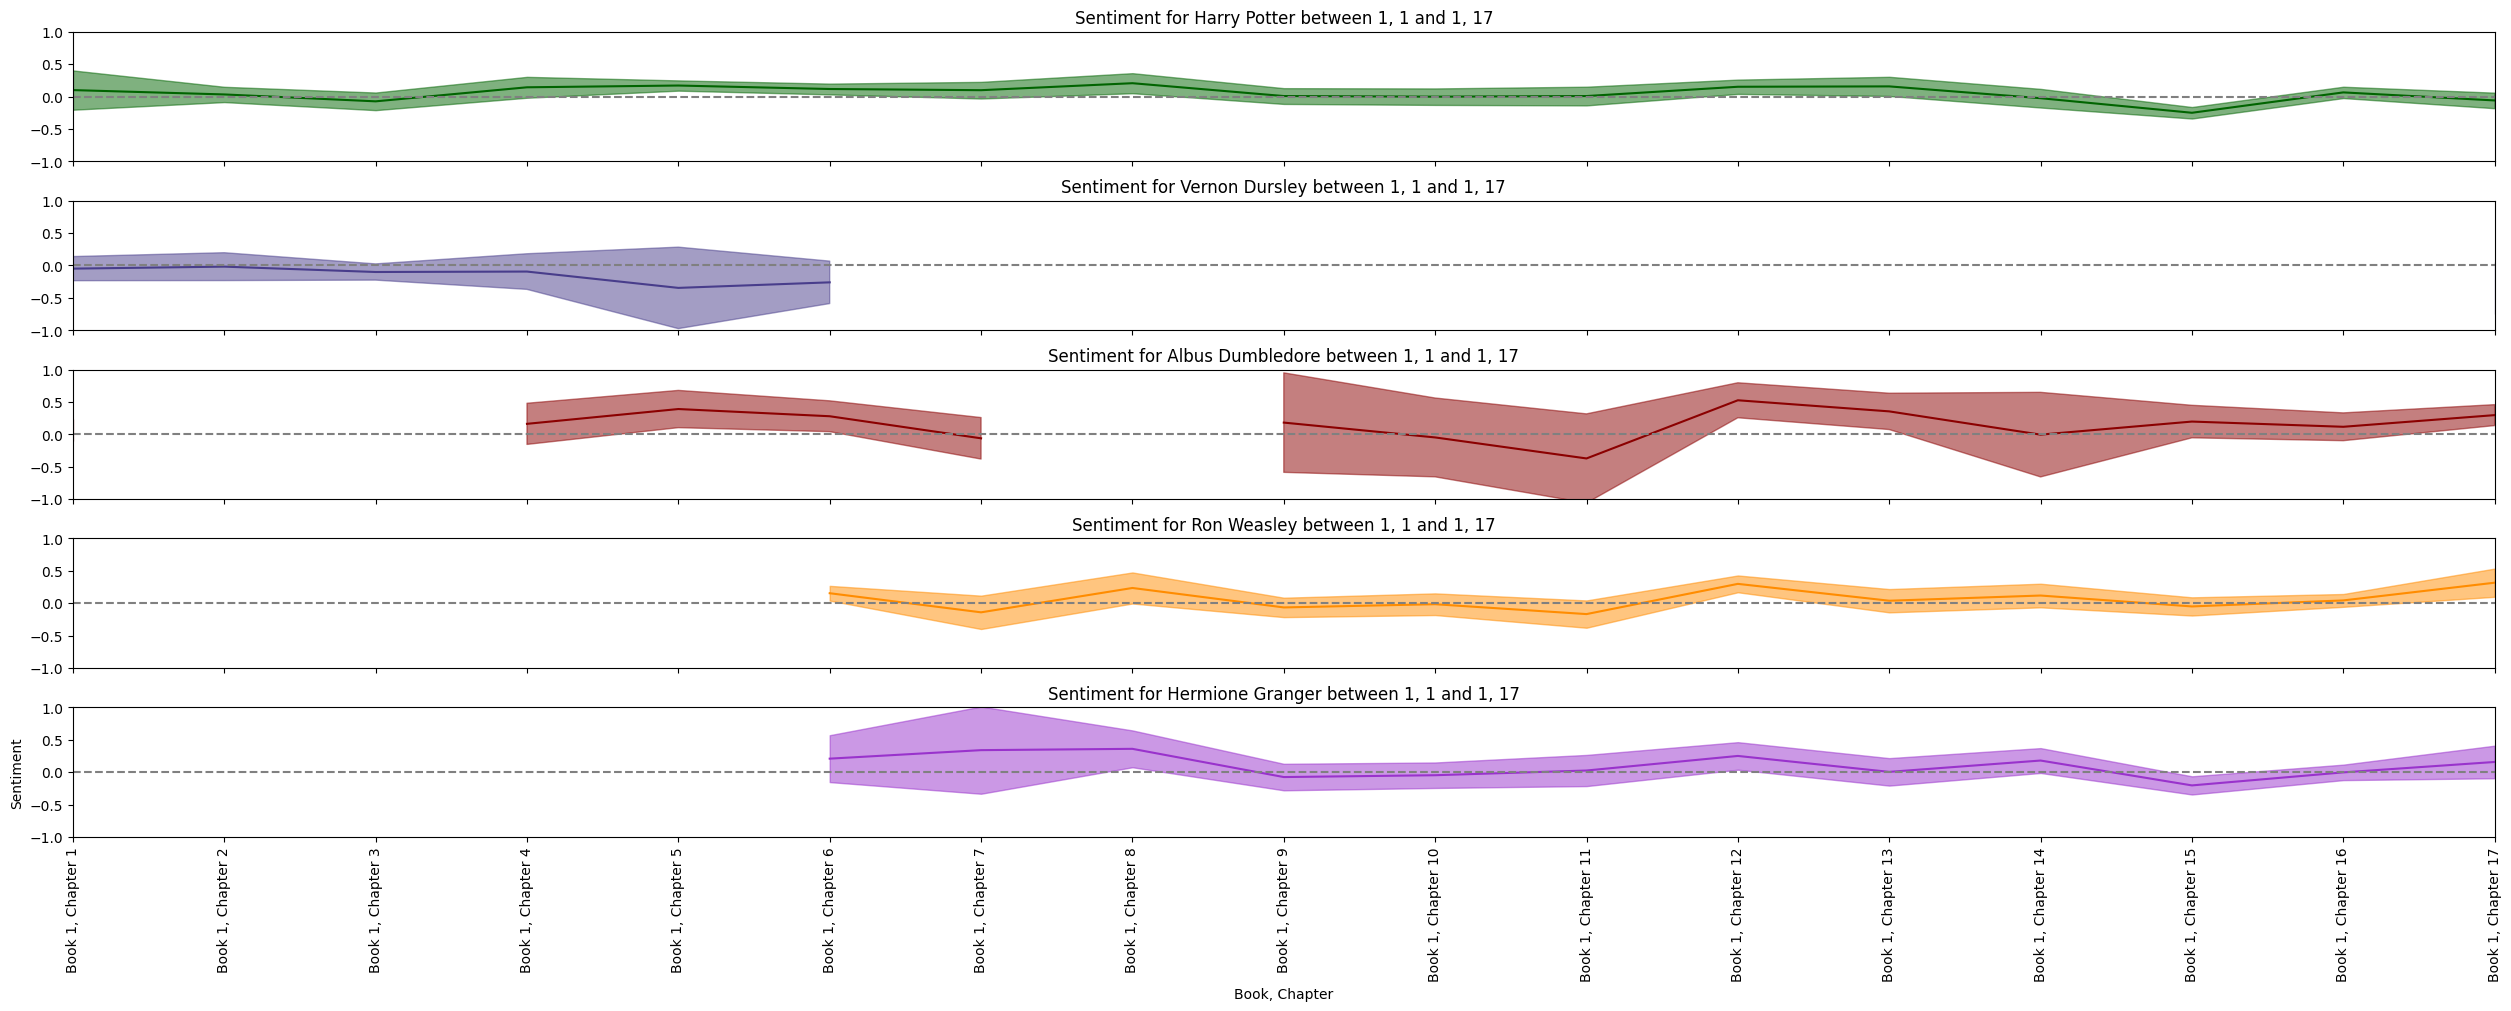

In [17]:
plot_sentiment(start=[1,1], stop=[1, 17],
characters_to_get=['Harry Potter', 'Vernon Dursley', 'Albus Dumbledore', 'Ron Weasley', 'Hermione Granger'],
colors = ['darkgreen', 'darkslateblue', 'darkred', 'darkorange', 'darkorchid'])

#### The Establishment of Dumbledore's Army

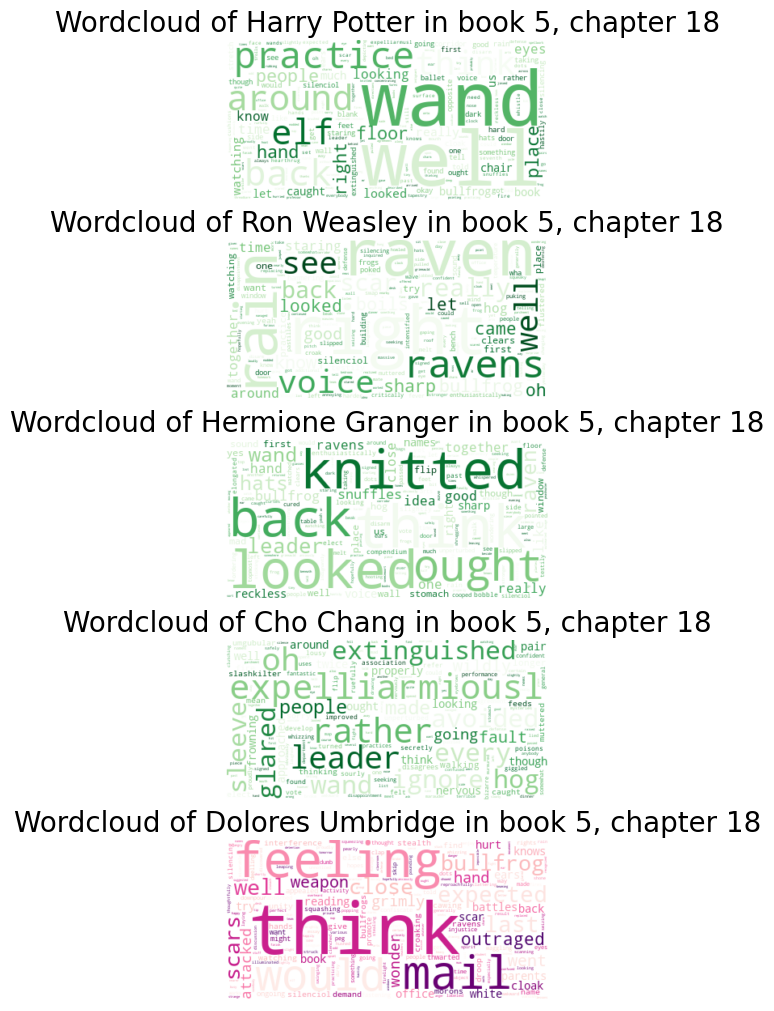

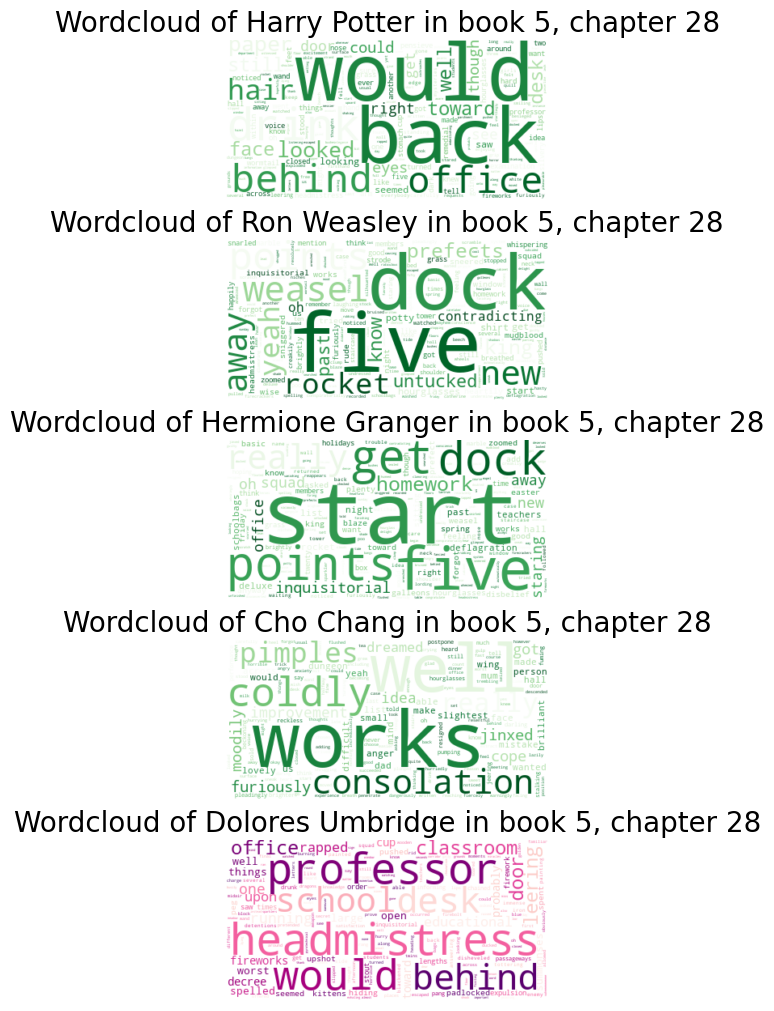

In [18]:
plot_wordcloud(characters_to_get = ["Harry Potter", "Ron Weasley", "Hermione Granger", "Cho Chang", "Dolores Umbridge"], position = [5,18], colormap = ["Greens"]*4 + ["RdPu"])
plot_wordcloud(characters_to_get = ["Harry Potter", "Ron Weasley", "Hermione Granger", "Cho Chang", "Dolores Umbridge"], position = [5,28], colormap = ["Greens"]*4 + ["RdPu"])

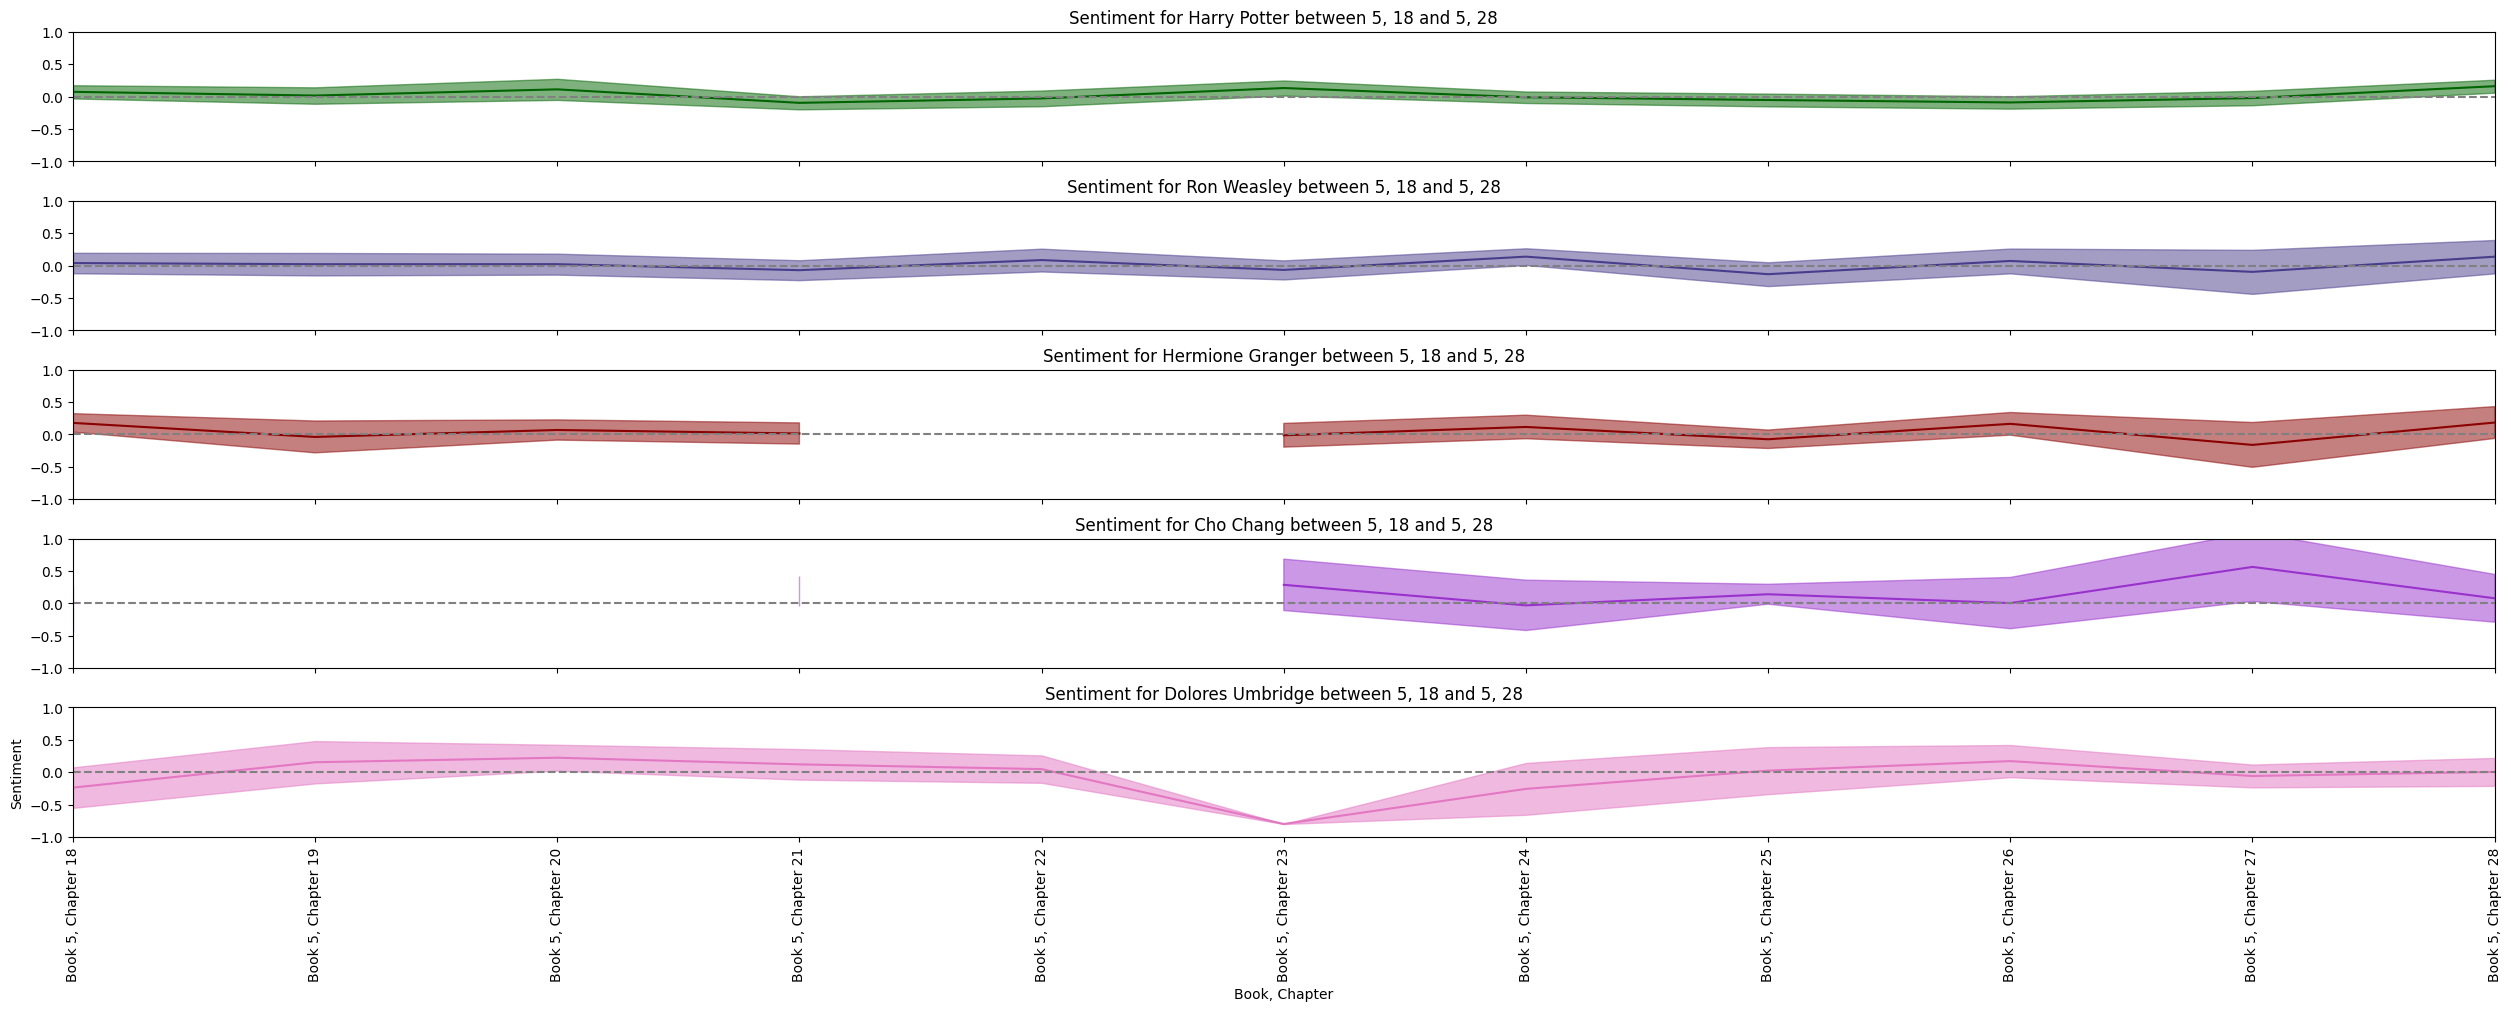

In [19]:
plot_sentiment(start=[5,18], stop=[5,28], characters_to_get=["Harry Potter", "Ron Weasley", "Hermione Granger", "Cho Chang", "Dolores Umbridge"], colors = ['darkgreen', 'darkslateblue', 'darkred', 'darkorchid', 'tab:pink'])

### Snape's True Allegiance

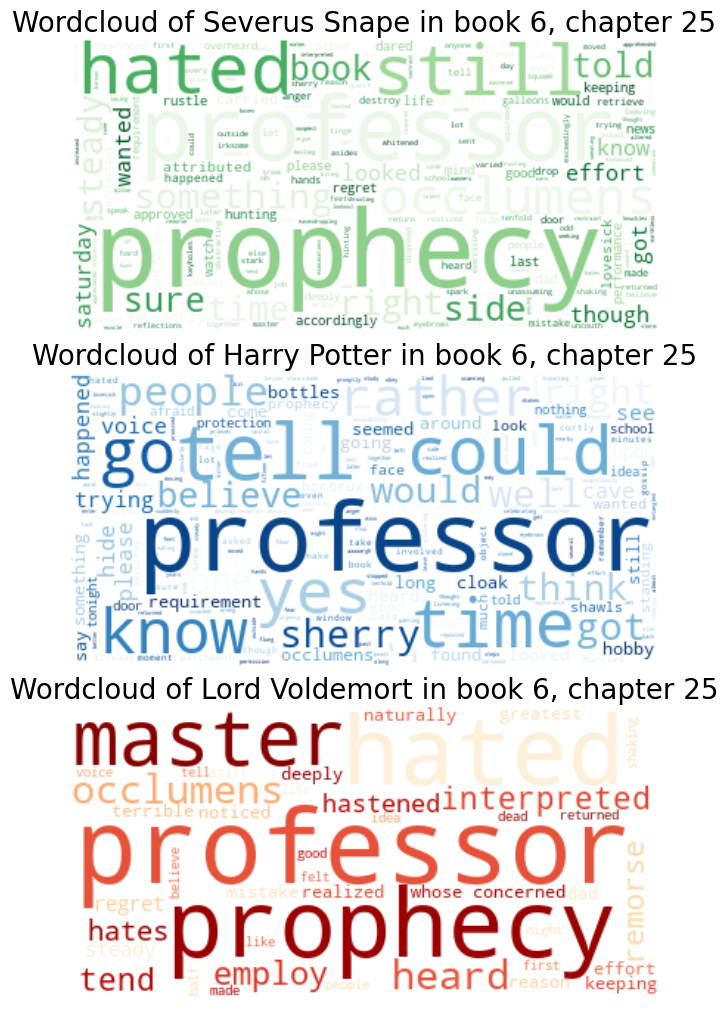

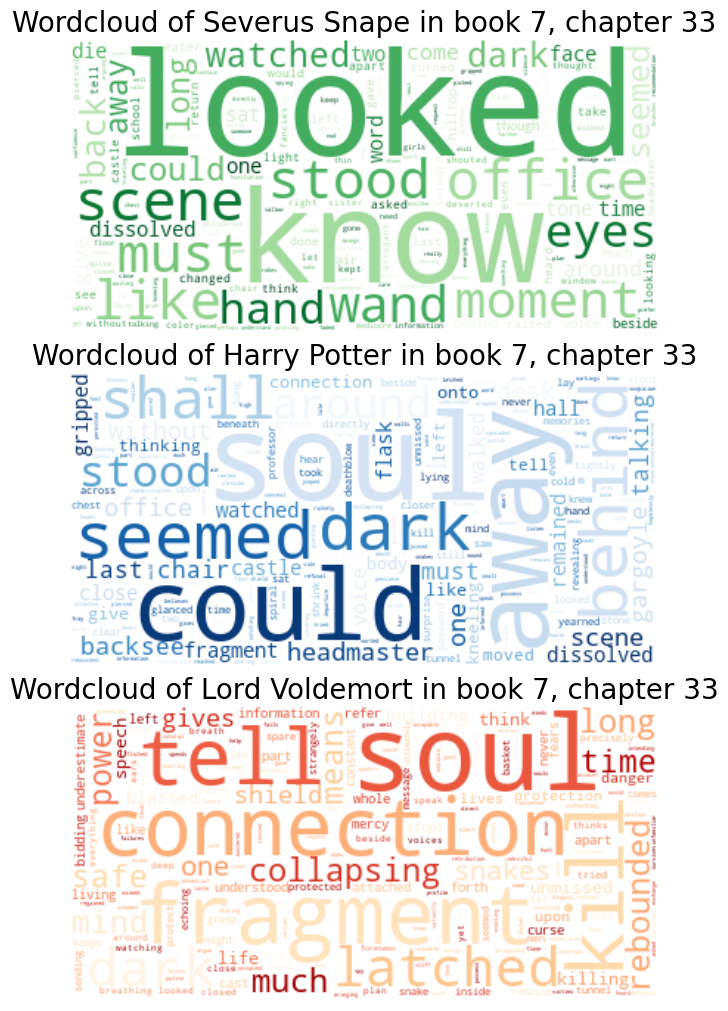

In [20]:
plot_wordcloud(characters_to_get = ["Severus Snape", "Harry Potter", "Lord Voldemort"], position = [6,25], colormap = ["Greens", "Blues", "OrRd"])
plot_wordcloud(characters_to_get = ["Severus Snape", "Harry Potter", "Lord Voldemort"], position = [7,33], colormap = ["Greens", "Blues", "OrRd"])

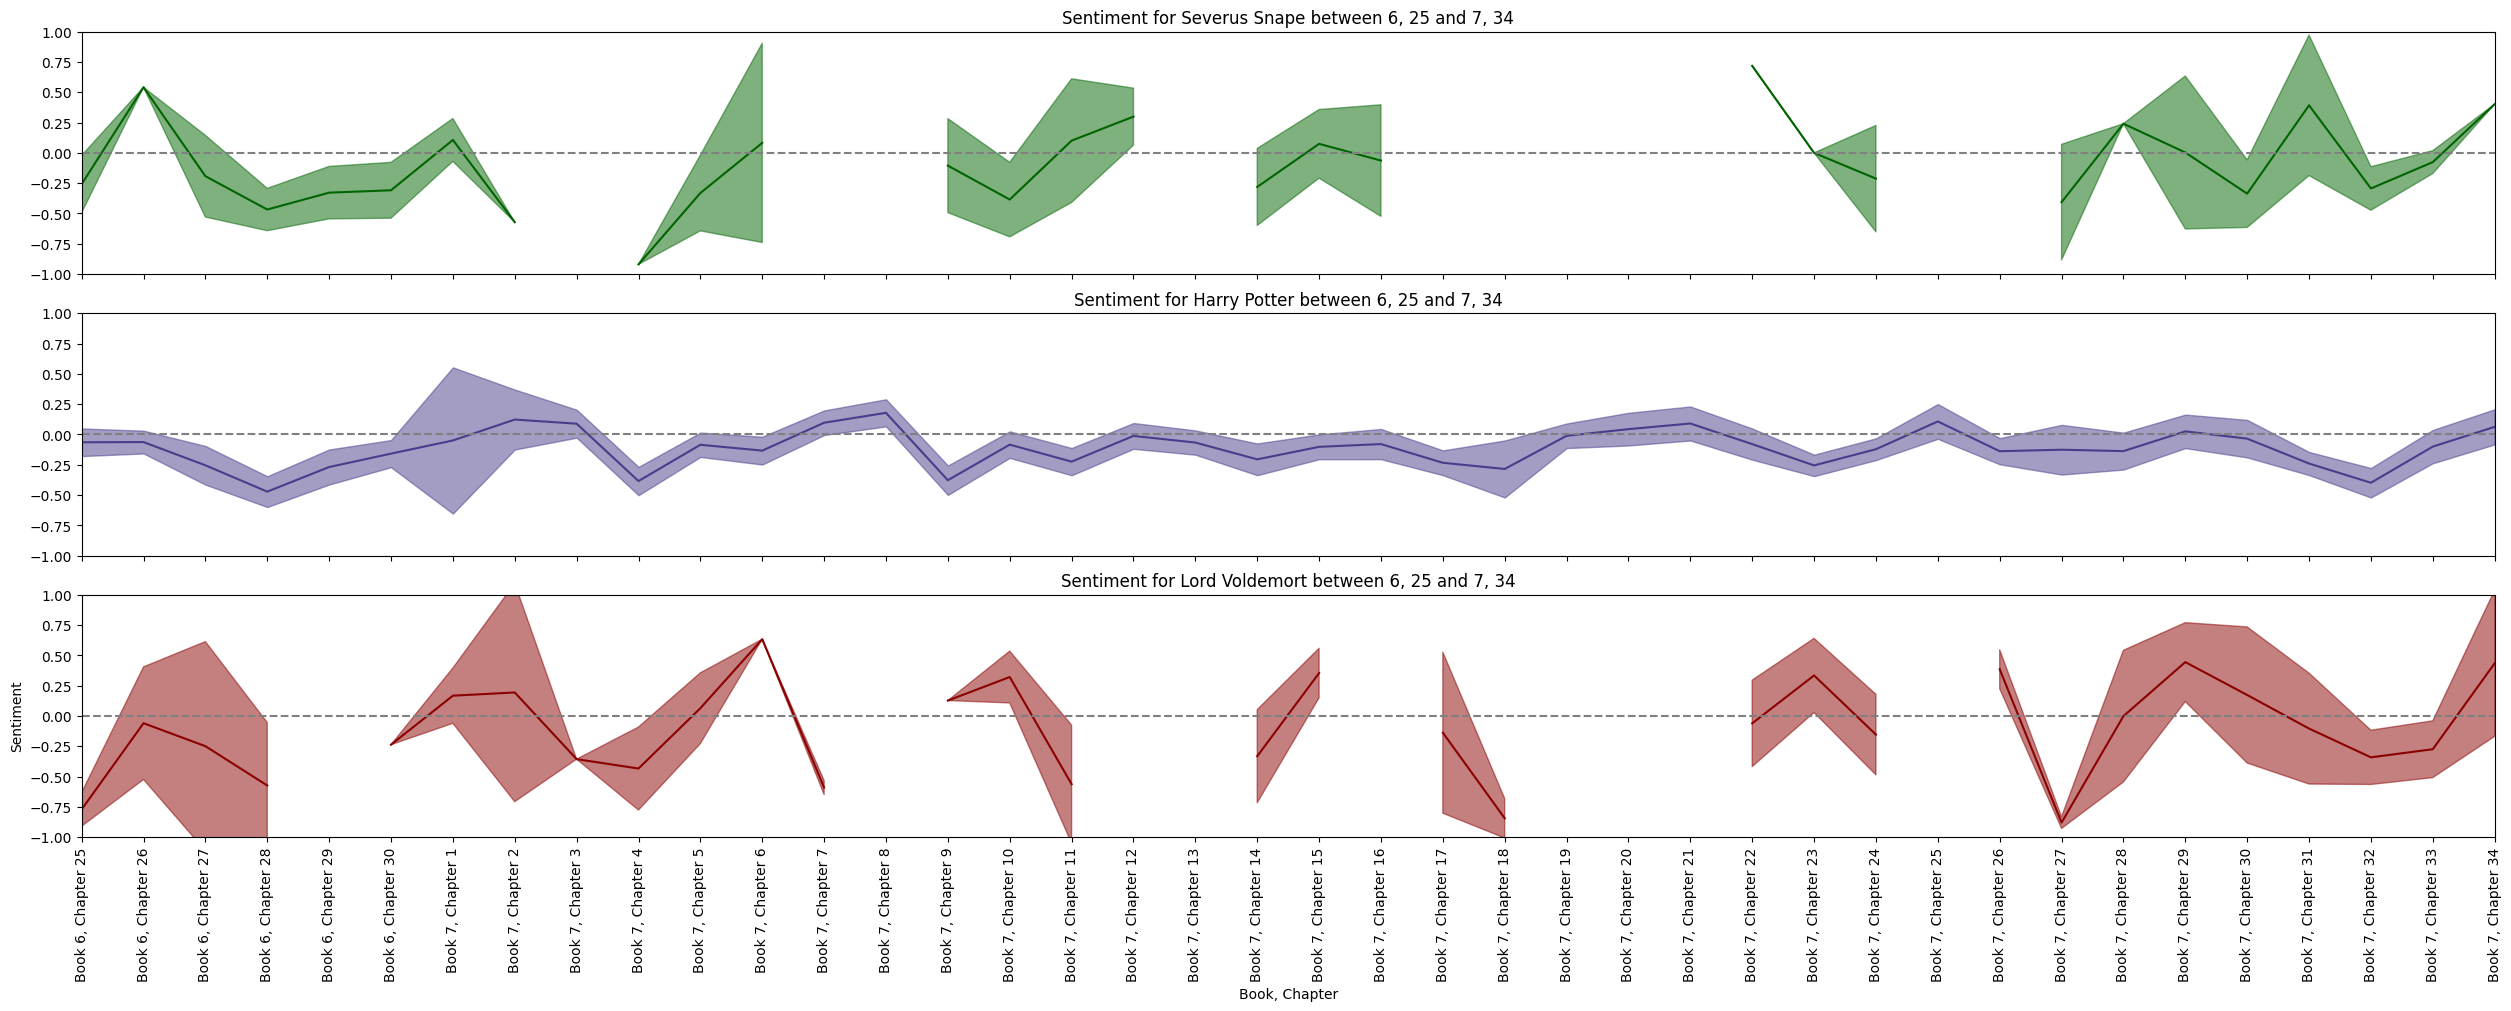

In [21]:
#Book 6, Chapter 26 vs. Book 7, Chapter 33: Severus Snape, Harry Potter, Lily Potter, James Potter, Albus Dumbledore (?), Lord Voldemort (?)
plot_sentiment(start=[6,25], stop=[7, 34], characters_to_get=['Severus Snape', 'Harry Potter', 'Lord Voldemort'], colors = ['darkgreen', 'darkslateblue', 'darkred'])

#### Sirius Black's and Peter Pettigrew's True Allegiance

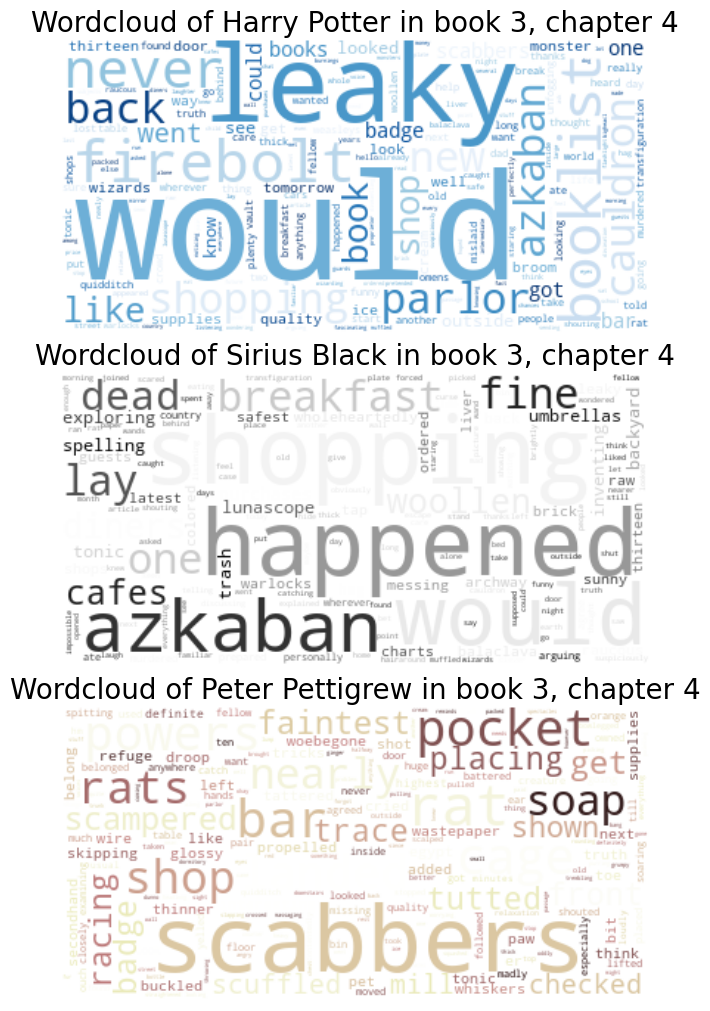

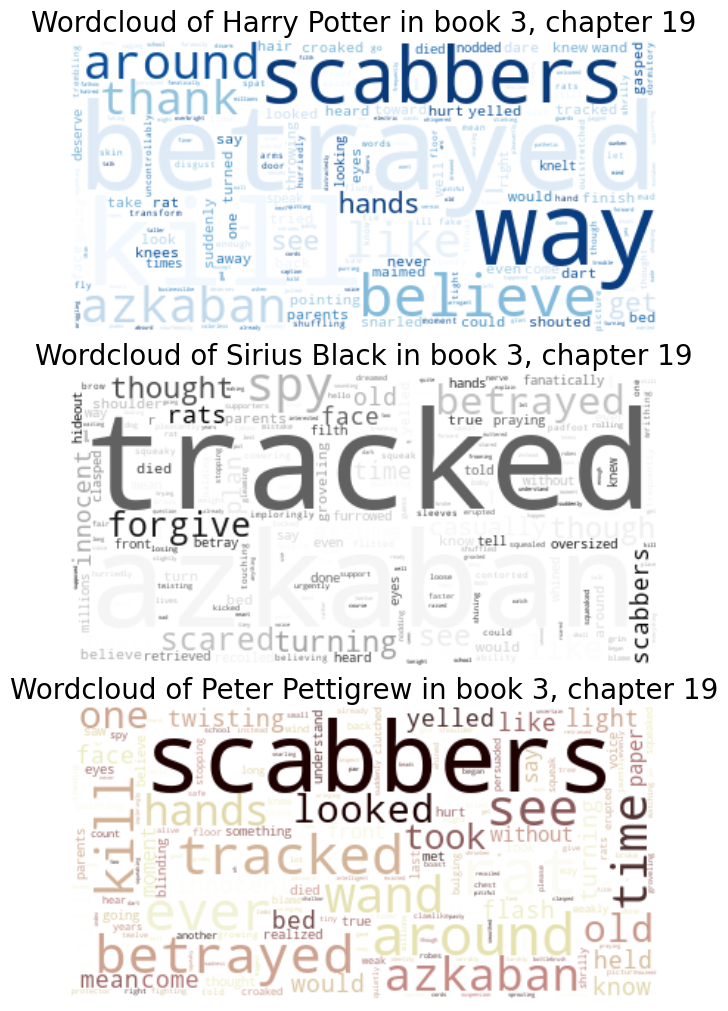

In [22]:
plot_wordcloud(characters_to_get = ['Harry Potter', 'Sirius Black', 'Peter Pettigrew'], position = [3,4], colormap = ['Blues', 'Greys', 'pink'])
plot_wordcloud(characters_to_get = ['Harry Potter', 'Sirius Black', 'Peter Pettigrew'], position = [3,19], colormap = ['Blues', 'Greys', 'pink'])

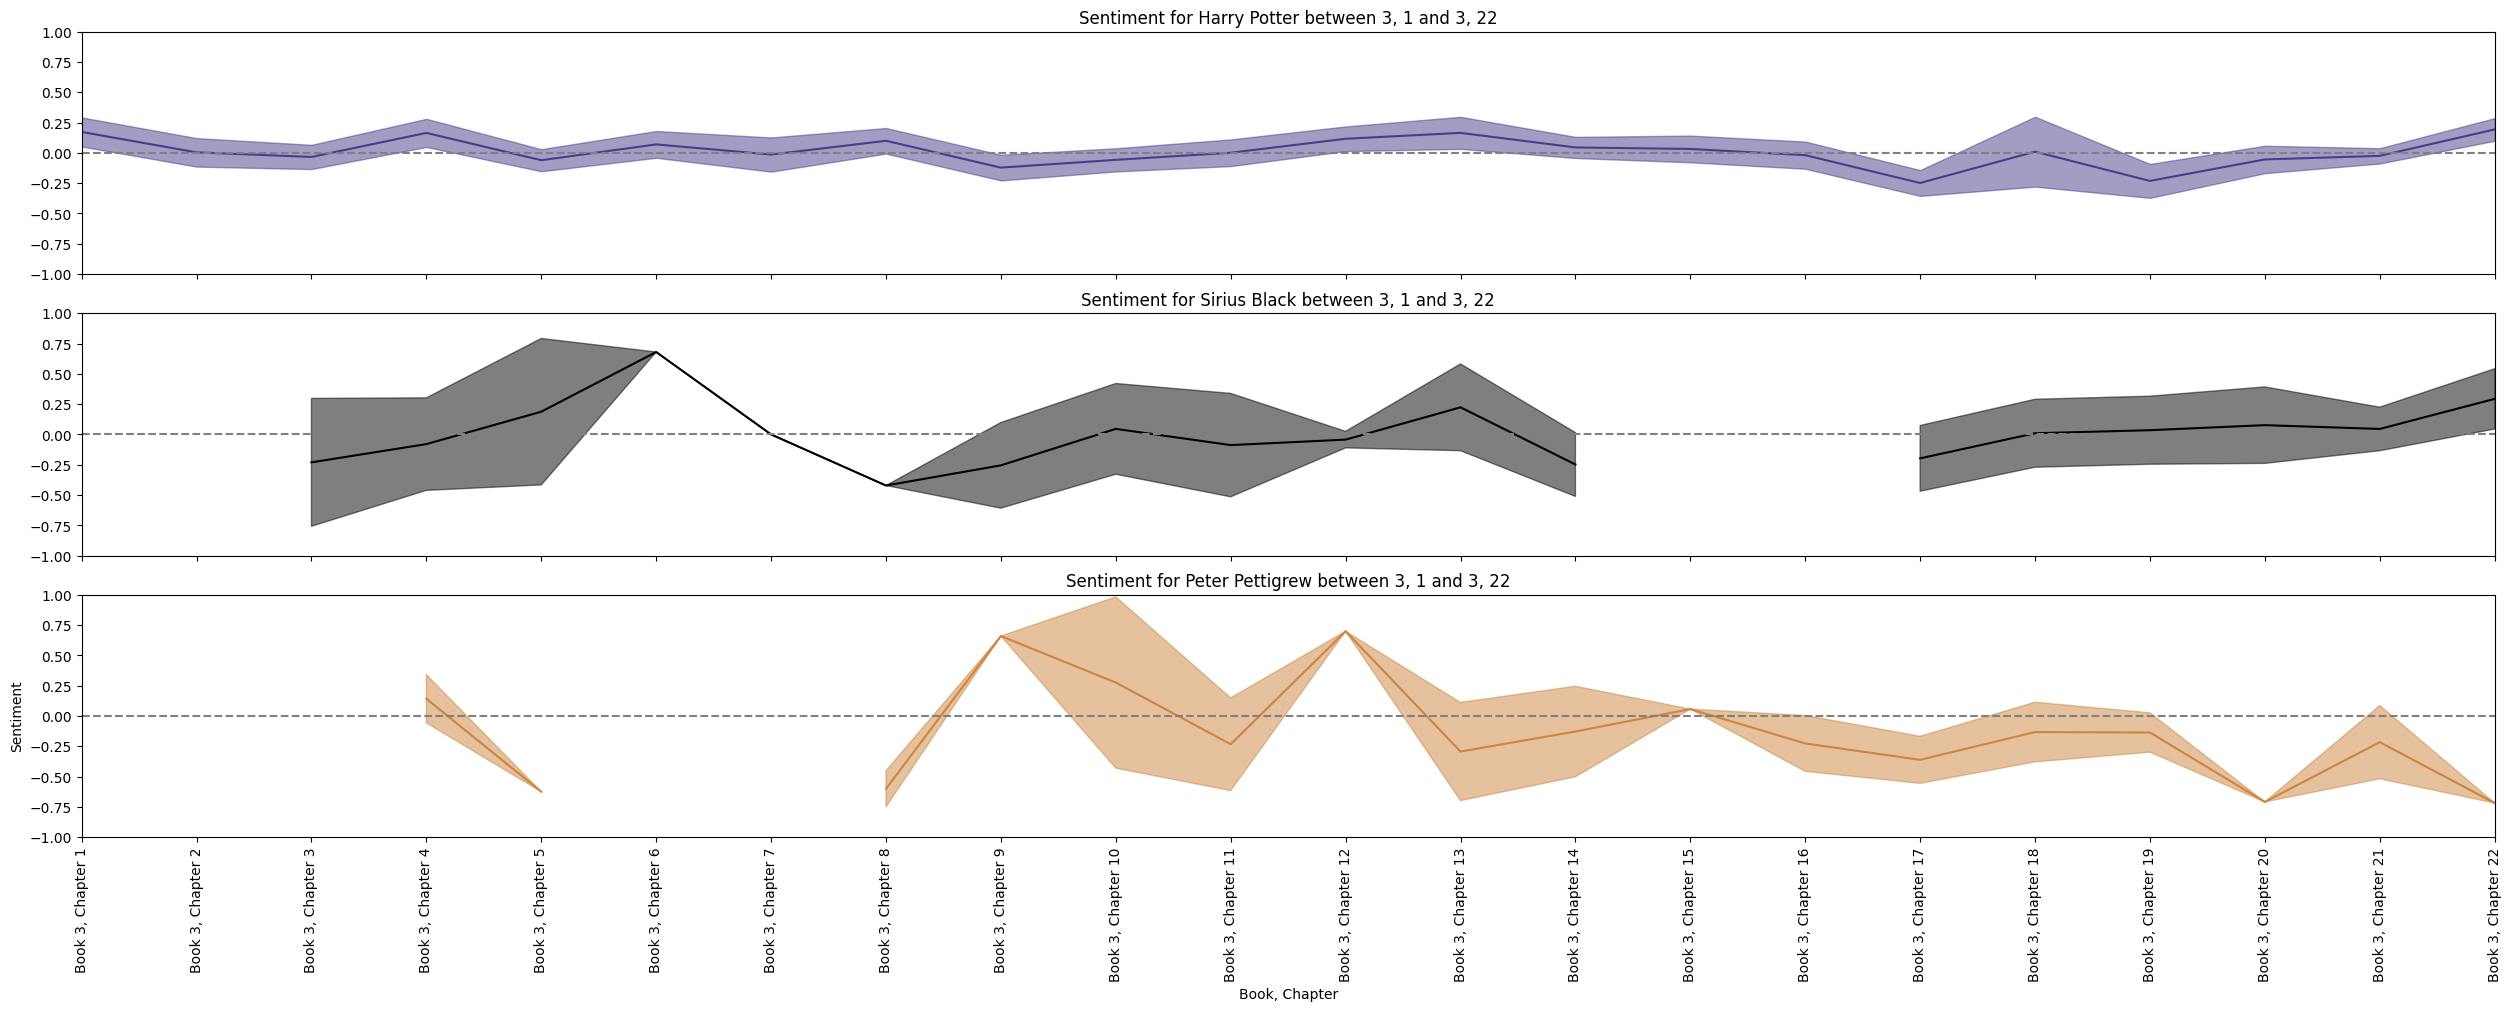

In [33]:
plot_sentiment(start=[3, 1], stop=[3, 22], characters_to_get=['Harry Potter', 'Sirius Black', 'Peter Pettigrew'], colors= ['darkslateblue', 'black', 'peru'])

In [39]:
alltexts['Sirius Black'][3][13]

{'text': ['“How did you do that?” squealed Angelina Johnson as George started throwing Peppermint Toads into the crowd. “With a little help from Moony, Wormtail, Padfoot, and Prongs,” Fred muttered in Harry’s ear. Only one person wasn’t joining in the festivities.',
  '“Black! Sirius Black! With a knife!” “What?” “Here!',
  '“Everyone back upstairs!” said Percy, hurrying into the common room and pinning his Head Boy badge to his pajamas as he spoke. “Perce — Sirius Black!” said Ron faintly. “In our dormitory!'],
 'tokens': ['squealed',
  'angelina',
  'johnson',
  'george',
  'started',
  'throwing',
  'peppermint',
  'toads',
  'crowd',
  'little',
  'help',
  'moony',
  'wormtail',
  'padfoot',
  'prongs',
  'fred',
  'muttered',
  'harry',
  'ear',
  'one',
  'person',
  'joining',
  'festivities',
  'black',
  'sirius',
  'black',
  'knife',
  'everyone',
  'back',
  'upstairs',
  'said',
  'percy',
  'hurrying',
  'common',
  'room',
  'pinning',
  'head',
  'boy',
  'badge',
  'p

In [26]:
alltexts['Merlin'][1]

{1: {'text': [], 'tokens': []},
 2: {'text': [], 'tokens': []},
 3: {'text': [], 'tokens': []},
 4: {'text': ['An’ I reckon it’s abou’ time yeh read yer letter.” Harry stretched out his hand at last to take the yellowish envelope, addressed in emerald green to Mr. H. Potter, The Floor, Hut-on-the-Rock, The Sea. He pulled out the letter and read: HOGWARTS SCHOOL o/WITCHCRAFT and WIZARDRY Headmaster: ALBUS DUMBLEDORE (Order of Merlin, First Class, Grand Sore., Chf. Warlock, Supreme Mugwump, International Confed.'],
  'tokens': ['reckon',
   'abou',
   'time',
   'yeh',
   'read',
   'yer',
   'harry',
   'stretched',
   'hand',
   'last',
   'take',
   'yellowish',
   'envelope',
   'addressed',
   'emerald',
   'green',
   'potter',
   'floor',
   'sea',
   'pulled',
   'letter',
   'read',
   'hogwarts',
   'school',
   'wizardry',
   'headmaster',
   'albus',
   'dumbledore',
   'order',
   'merlin',
   'first',
   'class',
   'grand',
   'chf',
   'warlock',
   'supreme',
   'mugwump

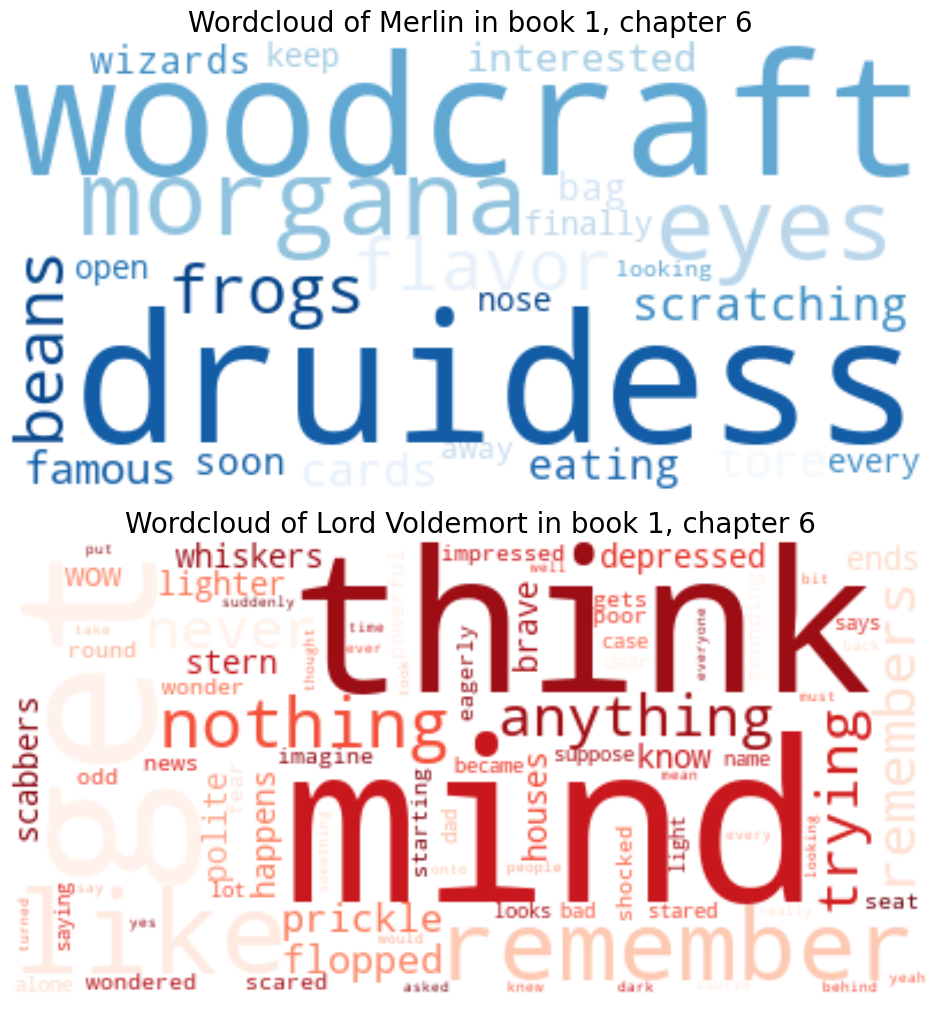

In [29]:
plot_wordcloud(characters_to_get = ['Merlin', 'Lord Voldemort'], position = [1,6], colormap = ['Blues', 'Reds'])

In [ ]:
alltexts['Merlin']

NameError: name 'alltexts' is not defined